In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from pprint import pprint
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
%matplotlib inline
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2

In [2]:
df = pd.read_csv('C:/Users/Jared/Dropbox/STUDY/Semester2/IR/Assessment/Text_Classification/text.csv')
df.tail()

,category,text
1528,3,"HISTORY: , The patient is a 5-1/2-year-old, wh..."
1529,3,"REASON FOR VISIT:, Six-month follow-up visit ..."
1530,3,"REASON FOR CONSULTATION:, Pericardial effusio..."
1531,3,"TITLE OF OPERATION: , Ligation (clip interrupt..."
1532,3,"PROCEDURE PERFORMED:, PICC line insertion.,DE..."


In [3]:
#df = df.sample(n = 300)

In [3]:
df.isnull().sum()

category    0
text        0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533 entries, 0 to 1532
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  1533 non-null   int64 
 1   text      1533 non-null   object
dtypes: int64(1), object(1)
memory usage: 24.1+ KB


In [5]:
len(df)

1533

In [6]:
df['category'].value_counts()

2    512
1    511
3    510
Name: category, dtype: int64

<AxesSubplot:xlabel='category', ylabel='count'>

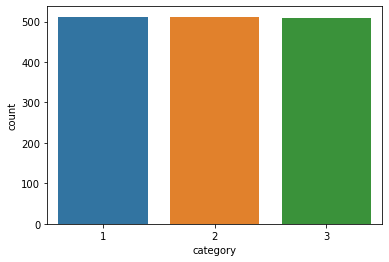

In [7]:
sns.countplot(x="category", data=df)

<AxesSubplot:>

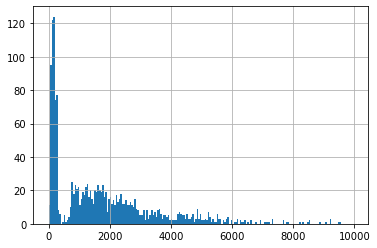

In [8]:
lens = df.text.str.len()
lens.hist(bins = np.arange(0,10000,50))

In [9]:
col = ['category', 'text']
df = df[col]
df = df[pd.notnull(df['text'])]
df.columns = ['category', 'text']

df['category_id'] = df['category'].factorize()[0]

category_id_df = df[['category',
                     'category_id']].drop_duplicates().sort_values('category_id')

category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
df.head()

,category,text,category_id
0,1,tigers wary of farrell gamble leicester say ...,0
1,1,yeading face newcastle in fa cup premiership s...,0
2,1,henman hopes ended in dubai third seed tim hen...,0
3,1,wilkinson fit to face edinburgh england captai...,0
4,1,moya emotional after davis cup win carlos moya...,0


In [10]:
df['text'][1111]

"PREOPERATIVE DIAGNOSIS: , Right lateral base of tongue lesion, probable cancer.,POSTOPERATIVE DIAGNOSIS: , Right lateral base of tongue lesion, probable cancer.,PROCEDURE PERFORMED:  ,Excisional biopsy with primary closure of a 4 mm right lateral base of tongue lesion.,ANESTHESIA: , General.,FINDINGS: , An ulceration in the right lateral base of tongue region.  This was completely excised.,ESTIMATED BLOOD LOSS:,  Less than 5 mL.,FLUIDS: , Crystalloid only.,COMPLICATIONS:,  None.,DRAINS:,  None.,CONDITION:,  Stable.,PROCEDURE:  ,The patient placed supine in position under general anesthesia.  First a Sweetheart gag was placed in the patient's mouth and the mouth was elevated.  The lesion in the tongue could be seen.  Then, it was injected with 1% lidocaine and 1:100,00 epinephrine.  After 5 minutes of waiting, then an elliptical incision was made around this mass with electrocautery and then it was sharply dissected off the muscular layer and removed in total.  Suction cautery was used

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [12]:
df['text'] = df['text'].map(lambda com : clean_text(com))
df['text'][1111] #sample of standardised data

'preoperative diagnosis right lateral base of tongue lesion probable cancer postoperative diagnosis right lateral base of tongue lesion probable cancer procedure performed excisional biopsy with primary closure of a 4 mm right lateral base of tongue lesion anesthesia general findings an ulceration in the right lateral base of tongue region this was completely excised estimated blood loss less than 5 ml fluids crystalloid only complications none drains none condition stable procedure the patient placed supine in position under general anesthesia first a sweetheart gag was placed in the patient mouth and the mouth was elevated the lesion in the tongue could be seen then it was injected with 1 lidocaine and 1 100 00 epinephrine after 5 minutes of waiting then an elliptical incision was made around this mass with electrocautery and then it was sharply dissected off the muscular layer and removed in total suction cautery was used for hemostasis then 3 simple interrupted 4 0 vicryl sutures w

In [13]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', 
                        encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.text).toarray()
labels = df.category
features.shape
# 1533 senteces with 9232 features,
#representing the tf-idf score for different unigrams and bigrams.

(1533, 9232)

In [14]:
N = 2
for text, category in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '0':
  . Most correlated unigrams:
. fasciotomy
. fibular
  . Most correlated bigrams:
. fascia reapproximated
. zurich premiership
# '1':
  . Most correlated unigrams:
. win
. said
  . Most correlated bigrams:
. champions league
. told bbc
# '2':
  . Most correlated unigrams:
. self
. citation
  . Most correlated bigrams:
. pro social
. self control


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'],
                                                    test_size=0.5, random_state = 0)

In [16]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [18]:
### CONSOLE TO CHECK CURRENT CLASS ### 
print(clf.predict(count_vect.transform(["a detailed mathematical representation of the student distribution"])))

[2]


In [19]:
X_test_counts = count_vect.fit_transform(X_test)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
X_train

965     to tease apart these accounts schwarz et al ci...
83      pearce keen on succeeding keegan joint assista...
966     participants rated themselves as more assertiv...
154     munster cup tie switched to spain munster s he...
1072    preoperative diagnoses left cubital tunnel syn...
                              ...                        
763     to explore our hypothesis that the problem of ...
835     the dynamics of a protein are very sensitive t...
1216    preoperative diagnoses left obstructed renal u...
559     at physiological firing rates stochastic gatin...
684     a detailed mathematical representation of the ...
Name: text, Length: 766, dtype: object

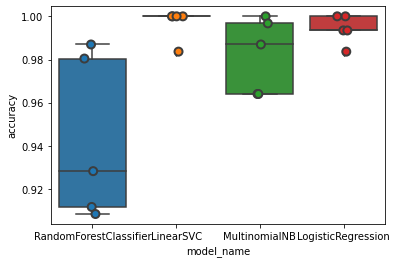

In [20]:
# Checking models accuracy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [55]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.996732
LogisticRegression        0.994122
MultinomialNB             0.982364
RandomForestClassifier    0.943205
Name: accuracy, dtype: float64

In [40]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features,
                                                                                 labels,
                                                                                 df.index,
                                                                                 test_size=0.5,
                                                                                 random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [46]:
y_test

479     1
1057    3
1366    3
298     1
651     2
       ..
1324    3
862     2
781     2
592     2
907     2
Name: category, Length: 767, dtype: int64

In [42]:
y_pred

array([1, 3, 3, 1, 2, 3, 3, 1, 3, 3, 1, 1, 3, 2, 2, 1, 1, 3, 2, 2, 3, 1,
       1, 1, 2, 2, 3, 1, 1, 3, 3, 1, 2, 3, 2, 3, 3, 3, 2, 2, 1, 2, 3, 2,
       2, 1, 3, 3, 3, 1, 3, 2, 3, 3, 3, 2, 3, 1, 2, 1, 1, 1, 3, 2, 3, 2,
       3, 1, 2, 3, 2, 1, 1, 1, 2, 1, 1, 3, 2, 2, 2, 1, 3, 3, 1, 1, 2, 2,
       1, 2, 3, 3, 1, 2, 1, 3, 2, 2, 2, 2, 2, 3, 1, 3, 3, 1, 3, 1, 2, 3,
       1, 1, 2, 1, 1, 2, 3, 2, 1, 2, 3, 3, 1, 1, 1, 3, 2, 1, 2, 3, 3, 2,
       2, 1, 2, 1, 3, 1, 3, 3, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 3,
       3, 3, 1, 2, 2, 2, 1, 3, 3, 2, 1, 3, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 3, 3, 1, 1, 2, 1, 2, 1, 2, 2, 2, 3, 3, 2, 3, 1, 2, 3, 3,
       3, 2, 3, 3, 3, 2, 1, 1, 3, 3, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 3, 3,
       2, 3, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 3, 2, 1, 1, 1, 1, 3, 2, 3, 1,
       3, 1, 3, 1, 2, 1, 2, 1, 1, 3, 1, 2, 2, 2, 1, 2, 1, 3, 3, 2, 2, 3,
       1, 2, 3, 2, 1, 1, 1, 1, 1, 2, 3, 1, 3, 1, 3, 1, 3, 2, 3, 1, 3, 2,
       1, 2, 2, 2, 2, 3, 3, 1, 1, 1, 2, 1, 2, 1, 2,

In [43]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[254,   0,   0],
       [  0, 252,   0],
       [  0,   0, 261]], dtype=int64)

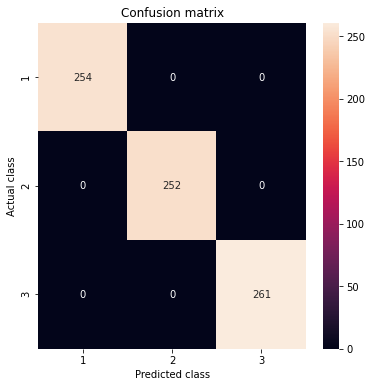

In [44]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.title('Confusion matrix')
plt.show()

In [47]:
target_names = ['Sport', 'Science', 'Health']

In [48]:
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Sport       1.00      1.00      1.00       254
     Science       1.00      1.00      1.00       252
      Health       1.00      1.00      1.00       261

    accuracy                           1.00       767
   macro avg       1.00      1.00      1.00       767
weighted avg       1.00      1.00      1.00       767



In [49]:
mnbc = MultinomialNB()
mnbc.fit(X_train, y_train)

MultinomialNB()

In [50]:
mnbc_pred = mnbc.predict(X_test)
mnbc_pred.shape

(767,)

In [51]:
### Training accuracy
print("The training accuracy is: ")
print(mnbc_pred)
print(accuracy_score(y_train, mnbc.predict(X_train)))

The training accuracy is: 
[1 3 3 1 2 3 3 1 3 3 1 1 3 2 2 1 1 3 2 2 3 1 1 1 2 2 3 1 1 3 3 1 2 3 2 3 3
 3 2 2 1 2 3 2 2 1 3 3 3 1 3 2 3 3 3 2 3 1 2 1 1 1 3 2 3 2 3 1 2 3 2 1 1 1
 2 1 1 3 2 2 2 1 3 3 1 1 2 2 1 2 3 3 1 2 1 3 2 2 2 2 2 3 1 3 3 1 3 1 2 3 1
 1 3 1 1 2 3 2 1 2 3 3 1 1 1 3 2 1 2 3 3 3 2 1 2 1 3 1 3 3 2 1 2 1 2 2 1 2
 2 2 1 1 1 3 3 3 1 2 2 2 1 3 3 2 1 3 1 1 3 1 1 1 2 1 1 1 1 1 2 3 3 1 1 2 1
 2 1 1 2 2 3 3 2 3 1 2 3 3 3 2 3 3 3 2 1 1 3 3 2 2 2 2 1 2 2 1 1 2 3 3 2 3
 1 1 1 1 2 1 2 2 1 2 3 2 1 1 1 1 3 2 3 1 3 1 3 1 2 1 1 1 1 3 1 2 2 2 1 2 1
 3 3 2 2 3 1 2 3 2 1 1 1 1 1 2 3 1 3 1 3 1 3 2 3 1 3 2 1 2 2 2 2 3 3 1 1 1
 2 1 2 1 2 1 2 1 3 3 3 2 1 3 2 2 3 2 2 3 2 1 2 2 1 3 2 1 3 2 2 3 1 3 2 1 3
 1 1 1 3 2 1 3 1 3 2 3 2 3 3 1 1 1 1 3 2 3 1 2 3 2 2 3 3 2 2 2 1 1 1 3 1 3
 3 3 2 1 1 2 3 2 3 2 3 3 3 3 1 3 1 3 3 3 1 3 2 2 2 1 2 2 1 2 2 3 1 3 1 2 3
 3 2 3 1 2 2 3 2 1 1 1 2 1 1 2 3 2 2 3 3 3 2 2 3 3 3 3 2 3 2 2 1 1 3 2 2 3
 3 2 2 2 1 3 1 1 1 2 3 2 3 3 3 3 3 2 3 3 2 3 2 1 3 2 2 3 2 1 1 2 1 2 2 2 

In [52]:
### Test accuracy
print("The test accuracy is: ")
print(accuracy_score(y_test, mnbc_pred))

The test accuracy is: 
0.9895697522816167
